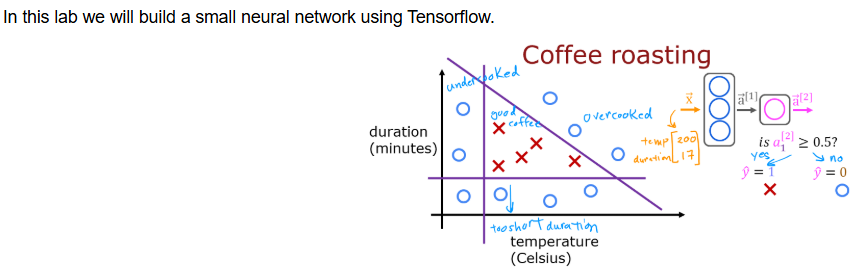

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv("coffee_roasting_data.csv")
print(df.head())

   Temperature   Duration  Roast
0   202.435617  14.210158      1
1   283.100003  11.420700      0
2   252.479152  11.808144      0
3   233.812188  15.492771      0
4   171.842610  14.032145      0


In [10]:
X = df.drop("Roast", axis=1)
Y = df["Roast"]
print(X.shape, Y.shape)

(200, 2) (200,)


In [5]:
Y = Y.to_numpy().reshape(-1, 1)  # Shape becomes (200, 1)
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [11]:
# Convert DataFrame X to NumPy
X = df[['Temperature', 'Duration']].values
Y = Y.values


Let's plot the coffee roasting data below

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define the plotting function
def plt_roast(X, Y):
    plt.figure(figsize=(8, 6))
    
    # Good roast (Y == 1)
    good = Y == 1
    plt.scatter(X[good, 0], X[good, 1], color='red', marker='X', label='Good Roast')
    
    # Bad roast (Y == 0)
    bad = Y == 0
    plt.scatter(X[bad, 0], X[bad, 1], edgecolors='b', facecolors='none', label='Bad Roast')
    
    # Labels and legend
    plt.xlabel("Temperature\n(Celsius)")
    plt.ylabel("Duration\n(minutes)")
    plt.title("Coffee Roasting")
    plt.legend()
    plt.grid(True)
    plt.show()


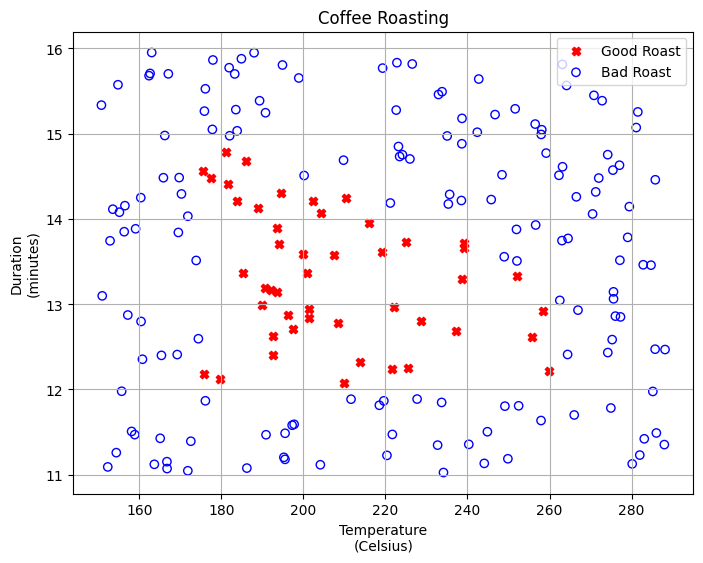

In [13]:
plt_roast(X,Y)

### Normalize Data
Fitting the weights to the data (back-propagation) will proceed more quickly if the data is normalized.

In [14]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 288.16, 150.77
Duration    Max, Min pre normalization: 15.95, 11.03
Temperature Max, Min post normalization: 1.71, -1.63
Duration    Max, Min post normalization: 1.66, -1.71


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [15]:
Xt = np.tile(Xn,(1000,1))
Yt = np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (1000, 200)


## Tensorflow Mode

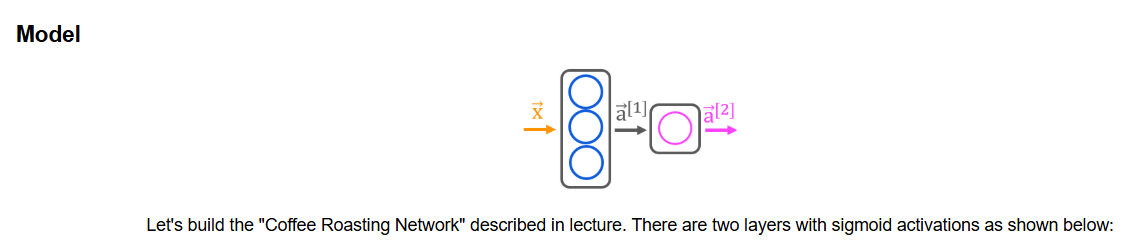

In [16]:
tf.random.set_seed(1234)  #applied to achieve consistent results

model = Sequential([
    tf.keras.Input(shape = (2,)),
    Dense(3, activation = "sigmoid", name = "layer1"),
    Dense(1, activation = "sigmoid", name = "layer2")
])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [18]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated. The weights  𝑊
  should be of size (number of features in input, number of units in the layer) while the bias  𝑏
  size should match the number of units in the layer:

In the first layer with 3 units, we expect W to have a size of (2,3) and  𝑏
  should have 3 elements.
In the second layer with 1 unit, we expect W to have a size of (3,1) and  𝑏
  should have 1 element.

In [19]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.10970628 -0.8980594  -0.48219758]
 [-0.86132574  0.23521638 -0.70356405]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.6293702]
 [ 1.1855308]
 [-1.0149351]] 
b2(1,): [0.]


The model.compile statement defines a loss function and specifies a compile optimization.

The model.fit statement runs gradient descent and fits the weights to the data.

In [20]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    X,Y,            
    epochs=10,
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5732  
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5624 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5549 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5503 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5479 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5469 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5466 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5467 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5468 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5470 


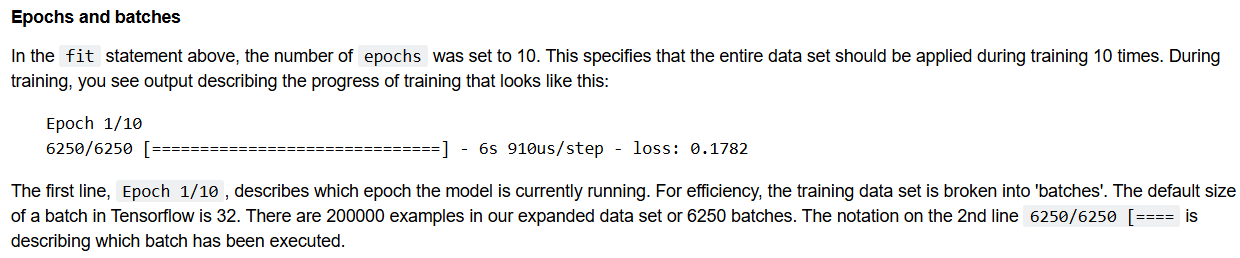

#### Updated Weights
After fitting, the weights have been updated: 

In [21]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ 0.18553892 -0.8980594  -0.48219758]
 [-0.78466696  0.23521638 -0.70356405]] 
b1: [0.07419943 0.         0.        ]
W2:
 [[-0.9380541]
 [ 1.1855308]
 [-1.0149351]] 
b2: [-0.3086661]


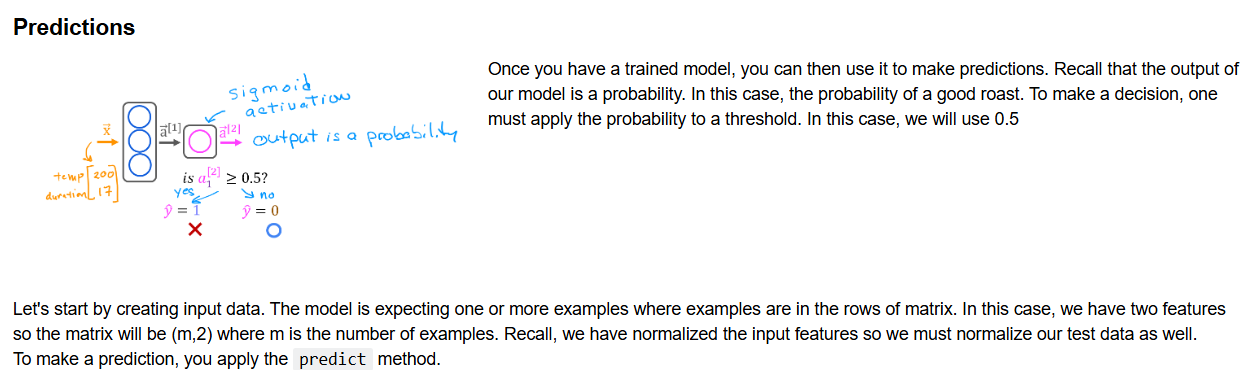

In [ ]:
X_test = np.array(
    [[200, 13.9], 
     [200, 17]   

    ]
)
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print(f"predictions:\n{predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
predictions:
[[0.37296554]
 [0.55734575]]


To convert the probabilities to a decision, we apply a threshold:

In [23]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1

    else :
        yhat[i] = 0
print(f"Predictions \n{yhat}")        



Predictions 
[[0.]
 [1.]]


This can be accomplished more succinctly:

In [24]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[0]
 [1]]


We have built a small neural network in Tensorflow. The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.